# Data Stack Preparation (data-prep)

This tutorial will walk you through the workflow of the [VegMapper](https://github.com/NaiaraSPinto/VegMapper) repo. At the end of this tutorial, you will create multi-band geotiffs that can be used for the identification and classification of specific agroforestry systems, such as palm-oil plantations.

## Prerequisites ##

The preliminary setup steps for this notebook can be found **here**. To summarize:

#### 1) Get credentials ####

This repo makes use of several third-party services which will require credentials. These can be obtained using the following links. Please note that approval of an account may take several days for certain services.

1) [NASA Earthdata](https://urs.earthdata.nasa.gov/users/new)

2) [JAXA](https://www.eorc.jaxa.jp/ALOS/en/palsar_fnf/registration.htm)

3) [Google Earth Engine](https://earthengine.google.com/)

Run the following cell to complete one-time authentication for Google Earth Engine, then continue to the next cells:

In [ ]:
import ee
ee.Authenticate()

#### 2) Set up vegmapper conda environment ####

This notebook should be launched from an AWS EC2 instance with the **vegmapper** conda environment activated. Anaconda can be downloaded [here](https://www.anaconda.com/products/individual).

Once Anaconda has been installed, clone the [VegMapper](https://github.com/NaiaraSPinto/VegMapper) repo by running the following command in your terminal:
```
% git clone https://github.com/NaiaraSPinto/VegMapper.git
```
Next, create the **vegmapper** environment and install required packages by running these commands in your terminal:

```
% cd VegMapper
% conda env create -f vegmapper.yml
% conda activate vegmapper
```

#### 3) Notebook Utilities ####
Run these cells before running the rest of the notebook.

In [5]:
# Utility function for plotting results

import geopandas as gp
# import contextily as cx

def plot(shape_file, fill_outline, fig_size, color="blue"):
    df = gp.read_file(shape_file[0])
    df = df.to_crs(epsg=3857)
    ax = None
    for i in range(0, len(shape_file)):
            df = gp.read_file(shape_file[i])
            df = df.to_crs(epsg=3857)
            if(fill_outline[i]):
                ax = df.plot(ax=ax, figsize=fig_size, color=color)
            else:
                ax = df.exterior.plot(ax=ax, figsize=fig_size)
#     cx.add_basemap(ax, url='http://a.tile.openstreetmap.org/tileZ/tileX/tileY.png')

In [4]:
# Utility function for formatting optional arguments

def format_arg(arg, flag):
    if len(arg) > 0:
        return f"{flag} {arg}"
    else:
        return ""

In [12]:
%automagic on


Automagic is ON, % prefix IS NOT needed for line magics.


In [13]:
alias_magic python run

Created `%python` as an alias for `%run`.


## Data Stack Workflow ##
The next steps will walk you through the creation of the data-stacks. 

## 1. Set up project directory ##

This repo will make use of one consistent project directory, referred from here as `proj_dir`. The name of `proj_dir` is up to you, but all subfolders and completed tiles will be generated automatically. The completed stacks as well as any intermediate products will be stored in `proj_dir`. At the moment, AWS S3 is supported, with GCS support coming in a future release.
   
`proj_dir` should be `s3://your_bucket/some_prefix` when used as an argument to scripts.

Once the entire workflow has been completed, `proj_dir` will contain the following subdirectories:

```
        proj_dir
           └──alos2_mosaic/
           └──landsat_ndvi/
           └──modis_tree_cover/
           └──sentinel_1/
           └──stacks/
           └──vrts/
```


In [56]:
# only use s3
# TODO: set up aoi_shp, csv/geojson in bucket beforehand

Set `proj_dir` to your project directory:

In [9]:
proj_dir = 's3://servir-public/dummy/'
proj_dir

's3://servir-public/dummy/'

Confirm that the notebook has access to `proj_dir` (empty output is fine, but an error message is not):

In [76]:
!aws s3 ls {proj_dir}

2022-02-09 19:23:39          0 


## 2. Prepare UTM tiles for Area of Interest (AOI): `prep_tiles.py` ##

To create the stacks, a universal tiling system is required to ensure all data sources are aligned to the same grid. In the following section, we will generate a geoJSON file that contains the tiles to be used by all of the data processing scripts. This is accomplished via the `prep_tiles.py` script.

#### Usage ####

```
(vegmapper) % python prep_tiles.py [-h] aoi_name aoi_shp tile_size
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`aoi_name`||Used to name the output geoJSON. The generated tiles can be found at `aoi_name`_tiles.geojson.||Yes||None|
|`aoi_shp`||shp/geoJSON file that contains the boundaries of our area of interest. geoJSON files for many subnational administrative boundaries can be found [here](https://data.humdata.org/dataset?ext_subnational=1&res_format=GeoJSON&vocab_Topics=administrative%20divisions&q=&sort=if(gt(last_modified%2Creview_date)%2Clast_modified%2Creview_date)%20desc&ext_page_size=25).||Yes||None|
|`tile_size`||The desired tile size, in meters.||Yes||None|

In [3]:
# Set arguments for prep_tiles.py
aoi_name = "ucayali"
s3_prefix = "servir-stacks/ucayali/" # if aoi_shp is in an s3 bucket, include the prefix separately
aoi_shp = "ucayali_boundary.geojson"
tile_size = 150000

aoi_name, aoi_shp, tile_size

('ucayali', 'ucayali_boundary.geojson', 150000)

If your geojson/shapefile is in an s3 bucket, copy it to the local directory here:

In [13]:
!aws s3 cp s3://{s3_bucket}{aoi_shp} . 

download: s3://servir-stacks/ucayali/ucayali_boundary.geojson to ./ucayali_boundary.geojson


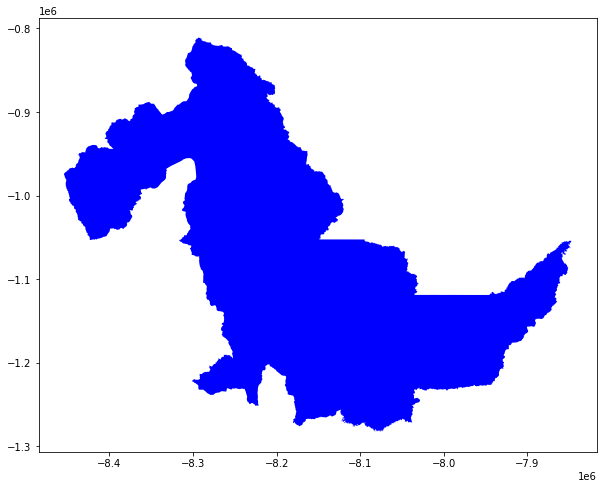

In [30]:
# Plot our AOI to make sure it looks right
fill_boundary = True
plot([aoi_shp], [fill_boundary], (10, 10))

Generate the UTM tiles by running the cell below:

In [15]:
python prep_tiles.py {aoi_name} {aoi_shp} {tile_size}

Tiles for Ucayali: ucayali_tiles.geojson
14 out of 20 tiles intersecting Ucayali


/opt/miniconda3/envs/vegmapper/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [22]:
# Set the value of aoi to the file containing the output tiles, to be used later in the notebook
aoi = f"{aoi_name}_tiles.geojson"
aoi

'ucayali_tiles.geojson'

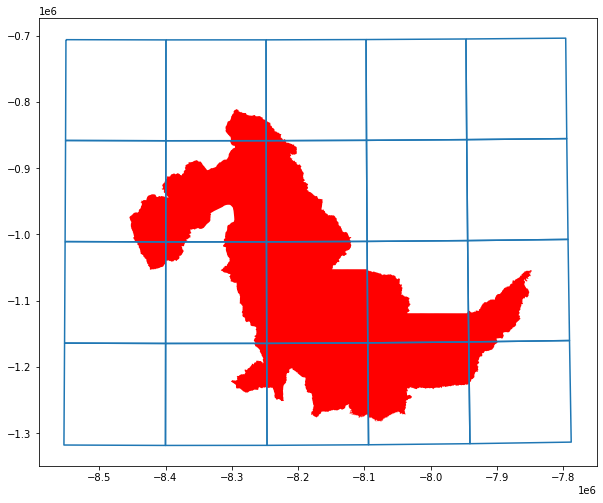

In [31]:
# Plot our tiles against our original AOI to make sure it looks right
fill_boundary = True
fill_tiles = False
plot([aoi_shp, aoi], [fill_boundary, fill_tiles], (10, 10), color=["red", "green"])

Note that some tiles might not intersect our AOI. These will be masked out and will not be used to generate the final stacks.

## 3. Prepare Sentinel-1 Tiles ##

The first piece of the data stack is Sentinel-1 tiles. In the following section, we search for granules within our AOI, process them using the ASF HyP3 API, and calculate statistics for the granules.

### Search for Sentinel-1 granules on [ASF Vertex](https://search.asf.alaska.edu/#/) ###

First, we must download a CSV or geoJSON file containing a list of granules we wish to submit for processing using the ASF Vertex Data Search tool.

1. Sign in using your Earthdata credentials, which were obtained in [the prerequisites section](#1\)-Get-credentials). If you haven't used ASF Vertex before, you will need to agree their terms in order to use their HyP3 processing.

2. Use the following "Additional Filters" when searching for granules within your AOI:

    * File Type: L1 Detected High-Res Dual-Pol (GRD-HD)
    * Beam Mode: IW
    * Polarization: VV+VH

    ![vertex_search_filters](img/vertex_search_filters.png)

3. Add the selected granules into the download queue:

    ![vertex_add_queue](img/vertex_add_queue.png)

4. Download metadata files. Download at least one csv or geojson file, which will be used for submitting HyP3 jobs.

    ![vertex_download_metadata](img/vertex_download_metadata.png)

5. Clear the selected granules in the downloads. Do not download these GRD-HD products as we will submit HyP3 jobs to apply radiometric terrain correction (RTC) to them.

Set `csv/geojson` to the CSV/geoJSON file we just downloaded:

In [15]:
csv_geojson = "granules/ucayali/ucayali_sentinel_granules_2017.geojson"
csv_geojson

'granules/ucayali/ucayali_sentinel_granules_2017.geojson'

### Submit HyP3 RTC jobs: `s1_submit_hyp3_jobs.py` ###

For the initial processing of the Sentinel-1 granules, we make use of ASF's HyP3 API. Information about the specifics of this processing can be found in the [HyP3 documentation](https://hyp3-docs.asf.alaska.edu/). `s1_submit_hyp3_jobs.py` will submit the granules chosen in the previous step to the HyP3 API for processing. The processed granules will be saved in the following directory structure, as .zip files:
```
        proj_dir
           └──sentinel_1
               └──<year>
                   └──<path_frame>
```

#### Usage ####

```
(vegmapper) % python s1_submit_hyp3_jobs.py [-h] proj_dir csv/geojson
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`proj_dir`||Your project directory (see [section 1](#1.-Set-up-project-directory)).||Yes||None|
|`csv/geojson`||CSV/geoJSON file that contains a list of granules to be submitted for processing. This was downloaded in the previous step.||Yes||None|

#### Notes ####

* Since ASF HyP3 stores the processed granules in their AWS S3 buckets, the data transfer will be much faster if you use an AWS S3 bucket for `proj_dir`.
* This script will require your Earthdata credentials, which can be obtained in [the prerequisites section](#1\)-Get-credentials).


    


Submit HyP3 RTC jobs for the granules we selected, and upload the results to `proj_dir`:

In [10]:
# Confirm arguments for s1_submit_hyp3_jobs.py
proj_dir, csv_geojson

('s3://servir-public/dummy/', 'Sentinel/granules/ucayali/ucayali_sentinel_granules_2017.geojson')

In [ ]:
python s1_submit_hyp3_jobs.py {proj_dir} {csv_geojson}

### Sentinel-1 Processing: `s1_proc.py` ###

The final processing step involves calculating the temporal mean for the Sentinel-1 granules and removing left/right (cross-track) edge pixels where border noise is prominent. `s1_proc.py` handles this final processing step. Two helper scripts in the Sentinel directory are used: `s1_build_vrt.py` and `calc_vrt_stats.py` for the calculating the temporal mean, and `remove_edges.py` for removing edge pixels. The results will be stored in the following directory structure, as .tif and .vrt files:
```
        proj_dir
           └──sentinel_1
               └──<year>
                   └──<path_frame>
```

#### Usage ####

```
(vegmapper) % python s1_proc.py [-h] [--pf path_frame] [--m1 m1] [--m2 m2] proj_dir year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`path_frame`||If specified, only granules matching `path_frame` will be processed.||No||all path_frames under srcpath/year will be processed|
|`m1`||If specified, only granules with acquisition month >= `m1` will be included in VRT||No||None|
|`m2`||If specified, only granules with acquisition month <= `m2` will be included in VRT||No||None|
|`proj_dir`||Your project directory (see [section 1](#1.-Set-up-project-directory)).||Yes||None|
|`year`||year of Sentinel-1 dataset||Yes||None|

#### Notes ####

* The processing will be slow if `proj_dir` is on AWS S3 or GCS because it requires heavy network I/O between the cloud and your local machine. If `proj_dir` is on AWS S3, it is strongly recommended that you run the processing on AWS EC2.

In [28]:
# Set arguments for s1_proc.py
path_frame = ""
m1 = ""
m2 = ""
year = 2017 # NOTE: this year will be used in later scripts

path_frame, m1, m2, proj_dir, year

('', '', '', 's3://servir-public/dummy/', 2017)

In [49]:
# Format optional arguments
path_frame = format_arg(path_frame, "--pf")
m1 = format_arg(m1, "--m1")
m2 = format_arg(m2, "--m2")

Perform the final processing step for our Sentinel-1 granules by running the cell below:

In [ ]:
python s1_proc.py {path_frame} {m1} {m2} {proj_dir} {year}

Show results in `proj_dir`:

In [ ]:
!aws s3 ls {proj_dir}sentinel_1/{year}/

## 4. Prepare ALOS-2 tiles ##

The next step of the data stack is ALOS-2 tiles. This involves downloading the ALOS-2 mosaic and processing them using an Enhanced Lee filter.

### Download ALOS/ALOS-2 Mosaic: `alos2_download_mosaic.py` ###

First, the ALOS-2 mosaic must be downloaded from the JAXA servers. This is accomplished via `alos2_download_mosaic.py`. The results will be stored in the following directory structure, as .tar.gz files:

```
        proj_dir
           └──alos2_mosaic
               └──<year>
                   └──tarfiles
```

#### Usage ####
```
(vegmapper) % alos2_download_mosaic.py [-h] proj_dir aoi year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`proj_dir`||Your project directory (see [section 1](#1.-Set-up-project-directory)).||Yes||None|
|`aoi`||The geoJSON file containing the tiles generated for your area of interest (see [section 2](#2.-Prepare-UTM-tiles-for-Area-of-Interest-(AOI):-prep_tiles.py)).||Yes||None|
|`year`||The year you wish to download the mosaic for (currently available for 2007-2010 and 2015-2019. This should be the same as the year used in the [sentinel-1 processing step](#Sentinel-1-Processing:-s1_proc.py).||Yes||None|

#### Notes ####

* Downloading ALOS/ALOS-2 Mosaic data requires a JAXA account, which can be obtained in [the prerequisites section](#1\)-Get-credentials).

Download the ALOS/ALOS-2 mosaic for your given AOI and year and upload the results to `proj_dir`:

In [23]:
# Confirm arguments for alos2_download_mosaic.py (all should have been set previously)
proj_dir, aoi, year

('s3://servir-public/dummy/', 'ucayali_tiles.geojson', 2019)

In [ ]:
python alos2_download_mosaic.py {proj_dir} {aoi} {year}

Show downloaded ALOS-2 tiles:

In [90]:
!aws s3 ls {proj_dir}alos2_mosaic/{year}/tarfiles/

2022-02-16 07:18:24  102942137 S06W076_19_MOS_F02DAR.tar.gz
2022-02-16 07:14:54  102632961 S06W077_19_MOS_F02DAR.tar.gz
2022-02-16 07:25:03  102027092 S07W076_19_MOS_F02DAR.tar.gz
2022-02-16 07:21:32  102905715 S07W077_19_MOS_F02DAR.tar.gz


### ALOS-2 Processing: `alos2_proc.py` ###
Next, the ALOS-2 mosaic is processed using an Enhanced Lee filter via `alos2_proc.py`. This will produce three .tif images for each tile: HV, HH, and INC, referring to the different polarizations of the ALOS-2 sensing instrument. Results will be stored in the following directory structure, as .tif files:
```
        proj_dir
           └──alos2_mosaic
               └──<year>
```

#### Usage ####

```
(vegmapper) % alos2_proc.py [-h] proj_dir year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`proj_dir`||Your project directory (see [section 1](#1.-Set-up-project-directory)).||Yes||None|
|`year`||The year you wish to download the mosaic for (currently available for 2007-2010 and 2015-2019. This should be the same as the year used in the [sentinel-1 processing step](#Sentinel-1-Processing:-s1_proc.py).||Yes||None|

Process the ALOS-2 mosaic:

In [ ]:
python alos2_proc.py {proj_dir} {year}

Show the processed tiles in `proj_dir`:

In [93]:
!aws s3 ls {proj_dir}alos2_mosaic/{year}/

                           PRE S06W076/
                           PRE tarfiles/


## 5) Prepare Landsat Tiles: `gee_export_landsat_ndvi.py` ##

The next step of the data stack is Landsat-8 tiles. This involves downloading the Landsat data, masking clouds, extracting the median, and computing the NDVI (Normalized Difference Vegetation Index). These processing steps are handled using Google Earth Engine. The results will be exported to your Google Drive, and will have to be manually copied to your `proj_dir`. Once completed, they will be stored in the following location:
```
        proj_dir
           └──landsat_ndvi
               └──<year>
```
#### Usage ####

```
(vegmapper) % gee_export_landsat_ndvi.py [-h] sitename tiles res year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|sitename||The name of the site. This is used in naming the final product.||Yes||None|
|tiles||The geoJSON file containing the tiles generated for your area of interest (see [section 2](#2.-Prepare-UTM-tiles-for-Area-of-Interest-(AOI):-prep_tiles.py)).||Yes||None|
|res||The resolution of the Landsat-8 tiles. L8 tiles are natively at 30x30m resolution. Any resampling will use bilinear interpolation.||Yes||None|
|year||The year to download the L8 dataset for (was set previously in this notebook).||Yes||None|


Export the Landsat-8 tiles to your Google Drive:

In [49]:
# Set arguments for gee_export_landsat_ndvi.py
sitename = "your_sitename"
res = 30
sitename, aoi, res, year

('your_sitename', 'ucayali_tiles.geojson', 30, 2017)

In [ ]:
python gee_export_landsat_ndvi.py {sitename} {aoi} {res} {year}

Create a folder in the data-prep directory titled `landsat`, and download all files locally into `data-prep/landsat`. Copy these files to `proj_dir` by running the following cell:

In [ ]:
!aws s3 cp landsat {proj_dir}landsat_ndvi/{year}/ -recursive

Show files in `proj_dir`:

In [ ]:
!aws s3 ls {proj_dir}landsat_ndvi/{year}/

## 6) Prepare MODIS Tree Cover Tiles: `gee_export_modis_tc.py` ##
The next step is MODIS Tree Cover Tiles. This involves downloading the MODIS dataset and extracting the Percent Tree Cover. The results will be exported to your Google Drive, and will have to be manually copied to your `proj_dir`. Once completed, they will be stored in the following location:
```
        proj_dir
           └──modis_tree_cover
               └──<year>
```
#### Usage ####

```
(vegmapper) % gee_export_modis_tc.py [-h] sitename tiles res year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|sitename||The name of the site. This is used in naming the final product.||Yes||None|
|tiles||The geoJSON file containing the tiles generated for your area of interest (see [section 2](#2.-Prepare-UTM-tiles-for-Area-of-Interest-(AOI):-prep_tiles.py)).||Yes||None|
|res||The resolution of the MODIS TC tiles. MODIS TC tiles are natively at 250x250m resolution. Any resampling will use bilinear interpolation.||Yes||None|
|year||The year to download the MODIS TC dataset for (was set previously in this notebook).||Yes||None|

Export the MODIS-TC tiles to your Google Drive:

In [47]:
# Set arguments for gee_export_landsat_ndvi.py
sitename = "your_sitename"
res = 30
sitename, aoi, res, year

('your_sitename', 'ucayali_tiles.geojson', 30, 2017)

In [ ]:
python gee_export_modis_tc.py {sitename} {aoi} {res} {year}

Create a folder in the data-prep directory titled `modis`, and download all files locally into `data-prep/modis`. Copy these files to `proj_dir` by running the following cell:

In [ ]:
!aws s3 cp modis {proj_dir}modis_tree_cover/{year}/ -recursive

Show files in `proj_dir`:

In [ ]:
!aws s3 ls {proj_dir}modis_tree_cover/{year}/

## 7) Build Stacks: `build_stacks.py` ##
The final step in the workflow is stacking all of the data into 8-band geotiffs using `build_stacks.py`. The bands are as follows, in order: C-VV / C-VH / C-INC / L-HH / L-HV / L-INC / NDVI / TC, where C-bands come from the Sentinel-1 dataset, and L-bands come from the ALOS-2 dataset. Completed stacks can be found in the following directory structure, as .tif files:
```
        proj_dir
           └──stacks
               └──<year>
                   └──all-bands
```
#### Usage ####

```
(vemapper) % build_stacks.py [-h] [--sitename sitename] proj_dir tiles year
```
|Arguments||Description||Required||Default|
|----||----||----||----|
|sitename||The name of the site. This is used in naming the final product.||No||Base directory of `proj_dir` will be used|
|proj_dir||Your project directory (see [section 1](#1.-Set-up-project-directory)).||Yes||None|
|tiles||The geoJSON file containing the tiles generated for your area of interest (see [section 2](#2.-Prepare-UTM-tiles-for-Area-of-Interest-(AOI):-prep_tiles.py)).||Yes||None|
|year||The year to produce the stacks for (was set previously in this notebook).||Yes||None|

Build the 8-band stacks for the specified year and area of interest:

In [48]:
# Set arguments
sitename = ''
sitename, proj_dir, aoi, year

('', 's3://servir-public/geotiffs/peru/', 'ucayali_tiles.geojson', 2017)

In [50]:
# Format optional arguments
sitename = format_arg(sitename, '--sitename')

In [ ]:
python build_stacks.py {sitename} {proj_dir} {aoi} {year}

Show results in `proj_dir`:

In [51]:
!aws s3 ls {proj_dir}stacks/{year}/all-bands/

Build a virtual raster containing all stack tiles to be used for analysis:

In [55]:
# !gdalbuildvrt ?